# Multimodal Review Summarizer

#### Part III: Review Summarization and Insights

In [1]:
# Import libraries
import json
import logging

import matplotlib.pyplot as plt
import ollama
import pandas as pd
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from textblob import TextBlob
from tqdm import tqdm

# Configure logging
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)

d:\Projects\multimodal-review-summarizer\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define a class for Customer Insights
class CustomerInsights:
    def __init__(self, model_name="llama3.2"):
        self.model_name = model_name
        self.embedding_model = SentenceTransformer(
            "sentence-transformers/all-MiniLM-L6-v2"
        )
        logging.info("CustomerInsights initialized with model: %s", self.model_name)

    # Prepare the data for analysis
    def prepare_reviews_data(self, df, product):
        logging.info("Preparing review data for selected product...")
        # Select reviews for the specified product
        df_reviews_filtered = df[df["parent_asin"] == product].copy()
        df_reviews_filtered["combined_text"] = (
            df_reviews_filtered["title"]
            + ". "
            + df_reviews_filtered["text"]
            + ". "
            + df_reviews_filtered["image_caption"]
        )
        df_reviews_filtered["timestamp"] = pd.to_datetime(
            df_reviews_filtered["timestamp"]
        )
        df_reviews_filtered.set_index("timestamp", inplace=True)
        return df_reviews_filtered

    # Perform sentiment analysis
    def get_sentiment(self, text):
        analysis = TextBlob(text)
        if analysis.sentiment.polarity > 0:
            return "positive"
        elif analysis.sentiment.polarity < 0:
            return "negative"
        else:
            return "neutral"

    # Cluster reviews
    def cluster_reviews(self, df):
        logging.info("Clustering reviews...")

        embeddings = self.embedding_model.encode(df["combined_text"].tolist())

        kmeans = KMeans(n_clusters=3, random_state=42)
        df["topic_cluster"] = kmeans.fit_predict(embeddings)
        logging.info("Clustering completed.")

        return df

    # Summarize customer insights
    def get_customer_insights(self, reviews):
        logging.info("Generating customer insights...")
        prompt = (
            "Analyze the following customer reviews on a humidifier. Provide insights in the following format:\n\n"
            "### Customer Insights Report ###\n"
            "1. **Sentiment Analysis**:\n"
            " - Overall Sentiment: [Positive/Negative/Neutral]\n"
            "a. **Key Positive Feedback**:\n"
            " - Summarize the most common positive aspects mentioned.\n"
            " - Include specific features or benefits that customers appreciate.\n"
            "b. **Key Negative Feedback**:\n"
            " - Summarize the most common negative aspects mentioned.\n"
            " - Include specific issues or complaints customers have.\n\n"
            "2. **Product Quality Issues**:\n"
            " - Detect any recurring product quality issues mentioned by customers.\n\n"
            "3. **Suggestions for Improvement**:\n"
            " - Provide recommendations based on customer feedback to improve the product.\n\n"
            "4. **Emerging Trends**:\n"
            " - Identify emerging trends in customer preferences and feedback.\n\n"
            "5. **Future Product Opportunities**:\n"
            " - Predict future product opportunities based on customer insights.\n\n"
            "6. **Competitor Benchmarking**:\n"
            " - Benchmark this product against competitors based on customer feedback.\n\n"
            "Customer Reviews:\n"
        )

        for i, review in enumerate(tqdm(reviews, desc="Processing reviews")):
            prompt += f"{i + 1}. {review}\n"

        # Chat interaction for text reviews
        text_response = ollama.chat(
            model=self.model_name, messages=[{"role": "user", "content": prompt}]
        )
        text_insights = text_response["message"]["content"]
        return text_insights

    # Plot monthly reviews and rating trends
    def plot_monthly_reviews(self, df, product):
        logging.info("Plotting monthly reviews and rating trends...")

        # Define a color mapping for ratings
        rating_colors = {
            1: "red",
            2: "orange",
            3: "lightblue",
            4: "lightgreen",
            5: "green",
        }

        # Group reviews by month and rating
        monthly_ratings_count = (
            df.groupby([df.index.to_period("M"), "rating"]).size().unstack(fill_value=0)
        )

        # Count the total reviews per month
        monthly_review_counts = df.resample("M").size().reset_index(name="review_count")
        monthly_review_counts["timestamp"] = (
            monthly_review_counts["timestamp"]
            .dt.to_period("M")
            .dt.to_timestamp("M", "end")
        )

        # Create the plot
        fig, ax = plt.subplots(figsize=(14, 7))

        # Plot each rating count
        for rating in range(1, 6):  # Ratings 1 to 5
            if rating in monthly_ratings_count.columns:
                ax.plot(
                    monthly_ratings_count.index.to_timestamp(how="end"),
                    monthly_ratings_count[rating],
                    label=f"{rating} Star",
                    marker="o",
                    linestyle="-",
                    color=rating_colors[rating],
                    markersize=6,
                )

        ax2 = ax.twinx()
        ax2.plot(
            monthly_review_counts["timestamp"],
            monthly_review_counts["review_count"],
            label="Reviews",
            color="black",
            marker="x",
            linestyle="--",
            markersize=8,
        )

        ax.set_xlabel("Month", fontsize=12)
        ax.set_ylabel("Count of Ratings", fontsize=12)
        ax2.set_ylabel("Count of Reviews", fontsize=12)
        ax.set_title(
            f"Monthly Ratings and Review Trends of Product {product}", fontsize=16
        )

        ax.grid(True, linestyle="--", alpha=0.7)
        lines, labels = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        fig.legend(
            lines + lines2,
            labels + labels2,
            loc="upper left",
            bbox_to_anchor=(0.1, 0.9),
            fontsize=10,
        )

        plt.tight_layout()
        plt.show()

        logging.info("Monthly reviews and rating trends plotted.")

    # Plot sentiment trends
    def plot_sentiment_trends(self, df, product):
        logging.info("Plotting sentiment trends...")
        df["sentiment"] = df["combined_text"].apply(self.get_sentiment)
        monthly_sentiment_counts = (
            df[df["sentiment"] != "neutral"]
            .resample("M")["sentiment"]
            .value_counts()
            .unstack(fill_value=0)
        )

        plt.figure(figsize=(12, 6))
        sns.lineplot(
            data=monthly_sentiment_counts,
            x="timestamp",
            y="positive",
            marker="o",
            label="Positive Sentiment",
            color="green",
        )
        sns.lineplot(
            data=monthly_sentiment_counts,
            x="timestamp",
            y="negative",
            marker="o",
            label="Negative Sentiment",
            color="red",
        )
        plt.title(
            f"Monthly Counts of Positive and Negative Sentiments of Product {product}",
            fontsize=14,
        )
        plt.xlabel("Month", fontsize=12)
        plt.ylabel("Count of Sentiments", fontsize=12)
        plt.legend(title="Sentiment", fontsize=10)
        plt.tight_layout()
        plt.show()
        logging.info("Sentiment trends plotted.")

    # Get insights for a specific product
    def get_insights_for_product(self, df):
        logging.info("Processing insights from reviews...")
        reviews_list = df["combined_text"].tolist()
        product_insights = self.get_customer_insights(reviews_list)
        return product_insights

In [3]:
# Load the data
with open("../data/filtered_reviews_with_img_captions.json") as f:
    reviews_json = json.load(f)

# Convert to DataFrame
df_reviews = pd.DataFrame(reviews_json)

# Get products IDs and their review counts
products = df_reviews["parent_asin"].value_counts()
print(f"Total unique products: {len(products)}")
print(products.head(10))

Total unique products: 11
parent_asin
B0BZJWPCHN    3862
B0BGVWR323    2638
B0C6G78JF8    1546
B0994K3LDF     869
B0BQ35GBM2     852
B0C56KFVKN     548
B07GDK79RQ     308
B0824Q5GXL      77
B0BSXRJ38L      60
B0BSYHV9X2      28
Name: count, dtype: int64


2025-09-17 02:23:43,579 - INFO - Use pytorch device_name: cpu
2025-09-17 02:23:43,580 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2025-09-17 02:23:44,682 - INFO - CustomerInsights initialized with model: llama3.2
2025-09-17 02:23:44,682 - INFO - Preparing review data for selected product...
2025-09-17 02:23:44,690 - INFO - Plotting monthly reviews and rating trends...
C:\Users\dipak\AppData\Local\Temp\ipykernel_3056\2502048538.py:106: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_review_counts = df.resample("M").size().reset_index(name="review_count")


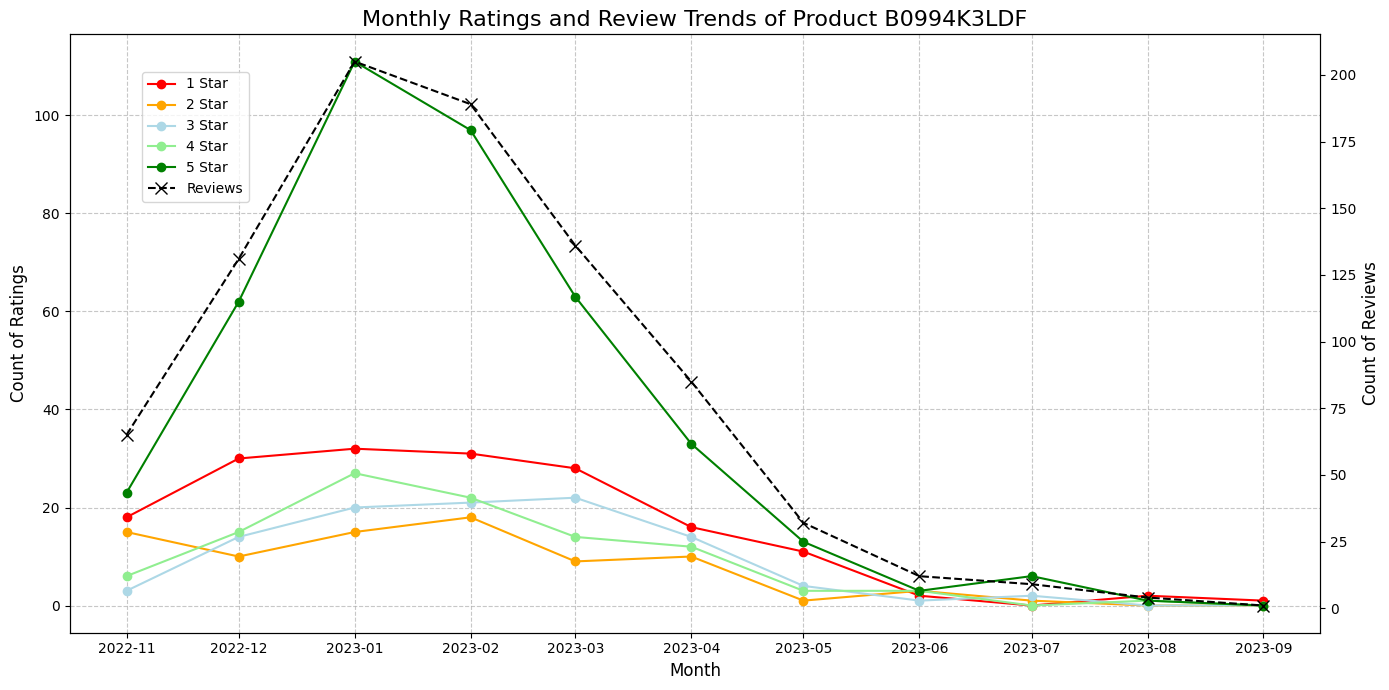

2025-09-17 02:23:45,035 - INFO - Monthly reviews and rating trends plotted.
2025-09-17 02:23:45,050 - INFO - Plotting sentiment trends...
C:\Users\dipak\AppData\Local\Temp\ipykernel_3056\2502048538.py:169: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M")["sentiment"]


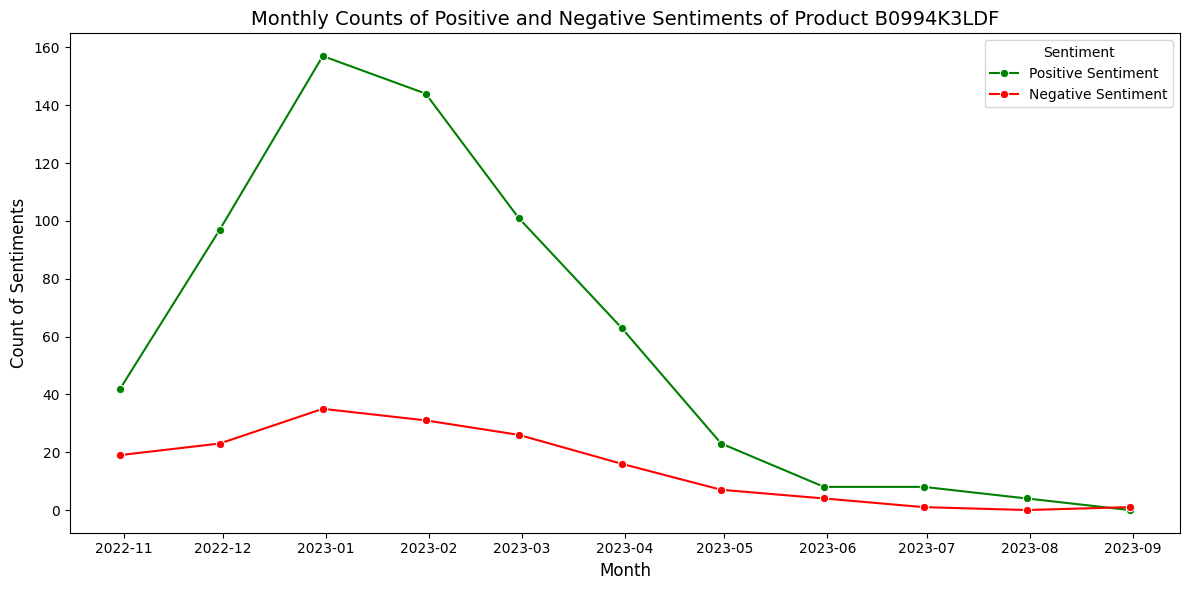

2025-09-17 02:23:45,653 - INFO - Sentiment trends plotted.
2025-09-17 02:23:45,653 - INFO - Processing insights from reviews...
2025-09-17 02:23:45,654 - INFO - Generating customer insights...
Processing reviews: 100%|██████████| 869/869 [00:00<00:00, 433910.74it/s]
2025-09-17 02:24:00,143 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Insights for B0994K3LDF:
Total review processed: 869
It seems that the reviews for this product are mixed, with some people having extremely positive experiences and others having negative ones. Here's a summary of the main points:

**Positive reviews:**

* Many reviewers praised the humidifier's ability to produce a consistent mist, its quiet operation, and its ease of use.
* Some reviewers appreciated the large water tank capacity, which can hold up to 50 hours of misting on one fill-up.
* The product is often described as beautiful and functional, with many reviewers enjoying the different options for controlling humidity and adding essential oils.
* Several reviewers mentioned that the company's customer service was excellent, particularly when it came to resolving issues or replacing faulty products.

**Negative reviews:**

* Some reviewers reported that the humidifier stopped working after a short period of use, often citing a failure in the motor or other component.
* A few revi

In [4]:
# Perform reviews analysis and generate customer insights
selected_product = products.index[3]
insights_processor = CustomerInsights()
df_reviews_filtered = insights_processor.prepare_reviews_data(
    df_reviews, selected_product
)
insights_processor.plot_monthly_reviews(df_reviews_filtered, selected_product)
insights_processor.plot_sentiment_trends(df_reviews_filtered, selected_product)
customer_insights = insights_processor.get_insights_for_product(df_reviews_filtered)

print(
    f"Insights for {selected_product}:\nTotal review processed: {len(df_reviews_filtered)}\n{customer_insights}\n"
)